In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad

# Evaluating the Parisi formula for a pure p-spin glass

The goal here is to calculate the zero-temperature Parisi constant, and compare it to the maximum satisfying fraction of randomXORSAT instances.

## Using the Parisi formula

Wei-Kuo Chen says:
> I am not aware of numerical simulations for the Parisi constant P(K) for large K. Nevertheless, this constant can be written as the Parisi formula, which is a convex optimization problem (see Theorem 1 in https://arxiv.org/pdf/1606.05335.pdf). With this, it should be fairly easy to run a numerical simulation to approximate P(K) for large K.


Paraphrased from the linked paper:
> We introduce the space $U$ that collects all nonnegative and nondecreasing functions $f$ on $[0,1)$ that are right continuous and satisfy $\int_0^1 f(t)dt < \infty$. Let's say $f$ has $k$ jumps. Then it has value $m_i$ in region $[q_i,q_{i+1})$, given $q_0 = 0$ and $q_{k+1} = 1$, where $m_i$ and $q_i$ are increasing and nonnegative. The distance metric $d$ is the integral of $f$, or equivalently, $d = \sum_{i=0}^k m_i(q_{i+1} - q_i)$.

$P(f) = \Psi_f(0, h) - 0.5 \int_0^1 t \xi^{''}(t)f(t) dt$

$\xi(s) =\sum_{p\ge 2} c_p^2 s^p$ Where the $c_p$'s are the mixing constants (mixed vs pure spin glasses).

$\partial_t \Psi_f(t,x) = -0.5\xi^{''}(t) 
\Big(
\partial_x^2 \Psi_f(t,x) + f(t) (\partial_x \Psi_f(t,x))^2
\Big)$

With boundary condition: $\Psi_f(1,x) = |x|$.

This can be solved recursively, by using the transformation $f(t) \Psi = \log \Phi$ for a piecewise, continuous function $f$.

This is the coefficient $a_{\ell} = \sqrt{ \xi^{'}(q_{\ell+1}) - \xi^{'}(q_{l}) }$

In [2]:
global k, xi, xiprime, xiprimeprime

In [3]:
def a(qs, l):
    return (xiprime(qs[l+1]) - xiprime(qs[l]))**0.5

Let $\Psi_{k+1}(x) = abs(x)$.

For $1\le \ell \le k$, let $Exp(m_{\ell} \Psi_{\ell}(x)) = \mathbb{E}[Exp(m_{\ell} \Psi_{\ell+1}(x + a_{\ell} z) ]$, for standard Gaussian variable $z$.

Let $\Psi_0(x) = \mathbb{E}[\Psi_{\ell+1}(x + a_{0} z)]$, since I let $m_0 = 0$.

In [4]:
def psi(qs, ms, l):
    offset = lambda x, z: psi(qs, ms, l+1)(x + a(qs, l)*z)
    if l == k+1:
        return lambda x: abs(x)
    elif l == 0:
        return Expectation(offset)
    else:
        return lambda v: 1/ms[l] * np.log(
            Expectation(lambda x, z: np.e**(ms[l]*offset(x,z)))(v)
        )

This defines the expectation value.

In [5]:
INPS = np.linspace(-20,20, 40001)
PDF_INPS = stats.norm.pdf(INPS)/1000
assert np.allclose(sum(PDF_INPS),1), sum(PDF_INPS)

In [6]:
def Expectation(f):
    # f is function of x and z, where z is gaussian
    return lambda x: np.sum(f(x,INPS)*PDF_INPS)

The penalty term in the operator is $0.5 \int_0^1 f(t)  t \xi^{''}(t) dt = 0.5 \sum_{i=0}^k \int_{q_i}^{q_{i+1}} m_i t \xi^{''}(t) dt$

In [7]:
def penalty(qs, ms):
    out = 0
    for i in range(k+1):
        integral = quad(lambda t: t * xiprimeprime(t), qs[i], qs[i+1])[0]
        out += ms[i] * integral
    return 0.5 * out

This tests the ground state energy of inputs **m**, **q**:

In [8]:
# the input here is a list of "adjustments" 
# (m_1, m_2-m_1, ...,m_k-m_{k-1}, q_1, q_2-q_1,...,q_k-q_{k-1})
def test(inp):
    assert len(inp) == 2*k
    inp_qs,inp_ms= inp[:k],inp[k:]

    # if bad input, return a large number
    if np.any(np.array(inp) < 0) or sum(inp_ms) > 1 or sum(inp_qs) > 1:
        return 10000

    qs = np.array([0,*[sum(inp_qs[:i+1]) for i in range(k)],1])
    ms = np.array([0,*[sum(inp_ms[:i+1]) for i in range(k)]])
    return psi(qs, ms, 0)(0) - penalty(qs, ms)

## Evaluating the Parisi formula

kXOR:
p: 2 1.883259140501375
p: 3 1.9927455249072779
p: 4 2.0219816154957764
p: 5 2.0321685235139206
p: 6 2.0362008561657907
p: 7 2.037915913208063
p: 8 2.0386779530175447
p: 9 2.0390260819660515
p: 10 2.0391880458926934
p: 11 2.0392643310453185
p: 12 2.0393005702436326
p: 13 2.0393178919308443
p: 14 2.0393262094756732
p: 15 2.0393302176125356
p: 16 2.039332154595943
p: 17 2.0393330928719315
p: 18 2.039333548280432
p: 19 2.039333769702445
p: 20 2.0393338775223278
p: 21 2.039333930095335
p: 22 2.039333955761009
p: 23 2.039333968304522
p: 24 2.0393339744409786
p: 25 2.039333977445775
p: 26 2.0393339789183464
p: 27 2.0393339796405563
p: 28 2.0393339799950354
p: 29 2.0393339801691255
p: 30 2.0393339802546677
p: 31 2.0393339802967247
p: 32 2.0393339803174193
p: 33 2.0393339803275907
p: 34 2.0393339803326
CPU times: user 1min 22s, sys: 5.75 ms, total: 1min 22s
Wall time: 1min 22s


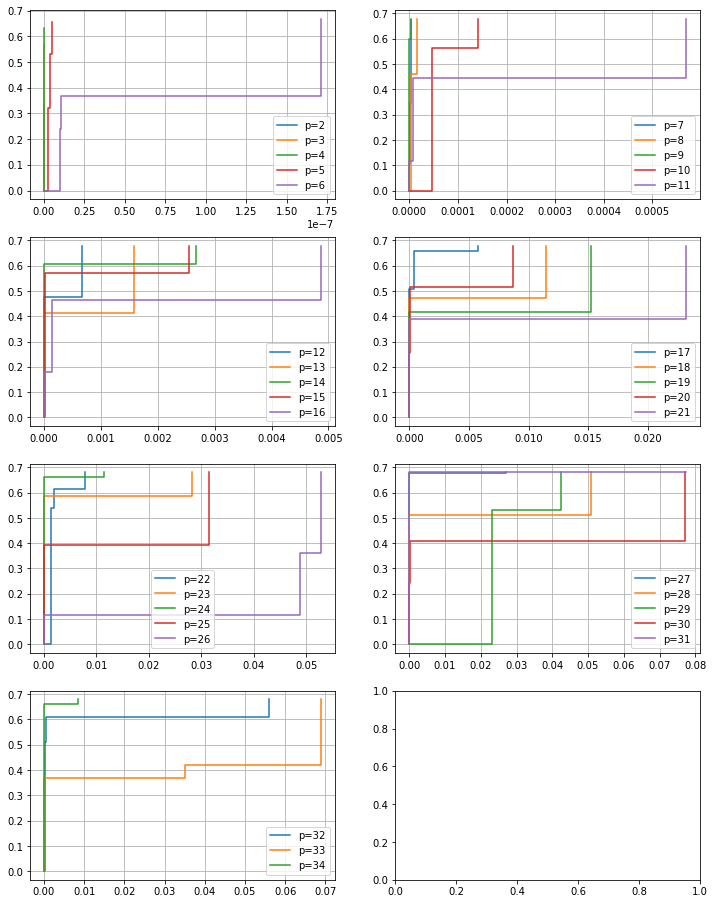

In [9]:
%%time

print("kXOR:")

# pure p-spin model; p=2 is SK model
ps = range(2, 35)
# number of jumps
k=3
# if C_psq is too low, my convergence is not very good.
C_psq = 3

num_vert_plots = int(np.ceil(len(ps)/10))
fig, axs = plt.subplots(num_vert_plots, 2, figsize=(12, 4*num_vert_plots))
outs = []
for idx in range(len(ps)):
    P = ps[idx]
    if idx % 5 == 0:
        ax = axs[idx // 10, (idx % 10)//5]
        ax.grid()
    # should xi be different by 1/2 ? I've seen it both ways.
    xi = lambda x: x**P * C_psq
    xiprime = lambda x: P * (x**(P-1)) * C_psq
    xiprimeprime = lambda x: P * (P-1) * (x**(P-2)) * C_psq
    
    # find best function from minimizer
    best = None
    for _ in range(4):
        opt = minimize(test, 
                       [np.random.random()/k for _ in range(2*k)], 
                       method='Powell', 
                       options={"xtol": 1e-10, "ftol":1e-14}
                      )
        if not best or best.fun > opt.fun:
            best = opt
    print("p:", P, best.fun)
    outs.append(best.fun)

    qs = np.array([0,*[sum(best.x[:k][:i+1]) for i in range(k)]])
    ms = np.array([0,*[sum(best.x[k:][:i+1]) for i in range(k)]])
#     print("qs:", qs)
#     print("ms:", ms)
    ax.step(qs, ms, where='post', label="p=" + str(P))
    if idx % 5 == 4:
        ax.legend()

ax.legend()
outs = np.array(outs)

I notice that the locations of the symmetry breaking points are often at very low values.  This may be related to the Auffinger Chen Zeng result that perturbing a solution to this variational near $1$ will reduce the energy. So perhaps perturbations very close to $0$ can also reduce the energy: https://doi.org/10.1002/cpa.21886

## Finding the large-p limit

Let's look at the constants after dividing out by $c_p$:

In [10]:
outs_scaled = np.array(outs)* C_psq**-0.5

In [11]:
for p, x in zip(ps, outs_scaled):
    print(p, x)

2 1.087300171722292
3 1.1505121652316388
4 1.1673916300029608
5 1.1732730440894463
6 1.1756011124314656
7 1.176591301076497
8 1.1770312649656347
9 1.1772322573077676
10 1.1773257672244135
11 1.1773698104778167
12 1.1773907331887186
13 1.177400733869493
14 1.177405536006239
15 1.1774078501051355
16 1.1774089684230271
17 1.1774095101369217
18 1.1774097730671418
19 1.1774099009052008
20 1.1774099631550392
21 1.177409993508079
22 1.177410008326163
23 1.1774100155681635
24 1.1774100191110484
25 1.1774100208458684
26 1.177410021696058
27 1.177410022113026
28 1.1774100223176844
29 1.1774100224181954
30 1.1774100224675832
31 1.1774100224918649
32 1.1774100225038129
33 1.1774100225096855
34 1.1774100225125776


In [12]:
guess = (2*np.log(2))**0.5

In [13]:
print(guess)

1.1774100225154747


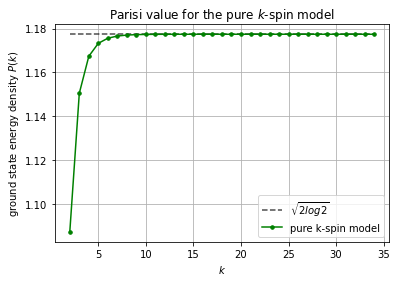

In [14]:
plt.plot(ps, [guess]*len(ps), 'b--', 
         color='black', label="$\sqrt{2 log 2}$", alpha=0.7)
plt.plot(ps, outs_scaled, 'g.-', ms=7,label="pure k-spin model")
plt.xlabel("$k$")
plt.ylabel("ground state energy density $P(k)$")
plt.title("Parisi value for the pure $k$-spin model")
plt.grid()
plt.legend()
plt.savefig('images/parisi_value.png', dpi=300)

## Relationship with $c_{p}$

I ran the above several times for different $c_p$. 
The asymptotic value seems to depend on the constant I use. If $c_p^2 < 2 log(2)$, The energy is $log(2) + c_p^2 / 2$. Otherwise, the energy is $\sqrt{ 2 c_p^2 log(2)}$.

Text(0, 0.5, '$energy / C_p$')

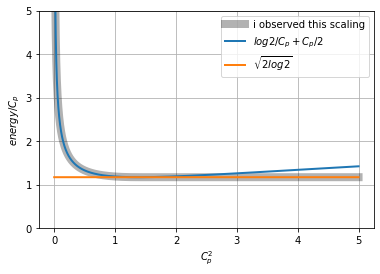

In [15]:
# this is what I observed after running for many different c_p^2
inps = np.linspace(1e-10, 5, 100000)
f1 = lambda x: x**-0.5 * (np.log(2) + x/2)
f2 = lambda x: x**-0.5 * (2 * x * np.log(2))**0.5

plt.plot(inps, [f1(i) if i < 2*np.log(2) else f2(i) for i in inps], 
         label='i observed this scaling',
         linewidth=8, alpha=0.3, color='black')
plt.plot(inps, f1(inps), label='$log 2/C_p +C_p/2$', linewidth=2)
plt.plot(inps, f2(inps), label='$\sqrt{2 log 2}$', linewidth=2)
# plt.plot(inps, inps**0.5, label='sqrt(x) (expected scaling)', linewidth=2)
plt.legend()
plt.grid()
plt.ylim(0,5)
plt.xlabel('$C_p^2$')
plt.ylabel("$energy / C_p$")

The minimum energy should be proportional to $c_p$. I think this means the limit of $P(p)$ is in fact $\sqrt{2 log 2}$.

This ended up being true, because of the relationship to the random energy model.

## Comparison with Montanari for Max 2XOR, Max 3XOR

This also roughly matches the calculation in https://arxiv.org/pdf/2009.11481.pdf that does Max 2XOR and Max 3XOR. They get
$$
e_2 = 0.763168\pm 0.000002
$$
and 
$$
e_3 = 0.8132\pm 0.0001
$$

Where $e_2$ uses $\xi(s) = s^2/2$ and $e_3$ uses $\xi(s) = s^3/2$.

In [23]:
for p, o in list(zip(ps, outs_scaled))[:2]:
    print("my result, p:", p, "e_p:", o * 2**-0.5)

my result, p: 2 e_p: 0.7688373246101304
my result, p: 3 e_p: 0.8135349538729095


The agreement gives me confidence that my approach is correct.

One way to improve my precision is to explicitly solve for the derivative, and use it in the optimization procedure (as the Montanari paper does).

## Using the Parisi constants in Sen's Max XOR upper bound

I insert these values for Subhabrata Sen's bounds for Max XOR on hypergraphs, as listed here: https://doi.org/10.1002/rsa.20774

The satisfying fraction for Max CUT on p-uniform hypergraphs is to first order in D: $\frac{1}{2}+ \frac{P_p \sqrt{p}}{2}\frac{1}{\sqrt{D}}$

This makes the satisfying fraction $\frac{1}{2} + \frac{C_p}{\sqrt{D}}$, where $C_p$ is listed below:

In [17]:
for p, x in zip(ps, outs_scaled):
    print(p, x * p**0.5 / 2)

2 0.7688373246101304
3 0.9963727624536387
4 1.1673916300029608
5 1.311759141376055
6 1.4398114332526841
7 1.5564839887051674
8 1.6645735782515607
9 1.7658483859616514
10 1.8615154862171803
11 1.9524469504233828
12 2.039300570243632
13 2.1225893588676934
14 2.202724060513138
15 2.280040497575534
16 2.3548179368460542
17 2.427291887450638
18 2.49766330431327
19 2.5661053865850048
20 2.6327687150001906
21 2.697785209624118
22 2.761271229413435
23 2.823330034262959
24 2.8840537648626583
25 2.943525052114671
26 3.0018183380639516
27 3.0590009694608344
28 3.1151341102076024
29 3.1702735081469564
30 3.224470143690799
31 3.27777078183455
32 3.3302184445978065
33 3.3818528174843197
34 3.4327106008897816


Because of the limit, we expect a large $p$XORSAT problem to have satisfying fraction at most

$$\frac{1}{2} + \frac{\sqrt{2 log 2}}{2} \sqrt{\frac{p}{D}} = \frac{1}{2} + \sqrt{\frac{p log 2}{2}} \frac{1}{\sqrt{D}} \approx \frac{1}{2} + 0.58871\sqrt{\frac{p}{D}}$$

## Bonus: Evaluating the $p$-SAT approximations

A similar formula to Sen has been done by Panchenko for $p$-SAT: https://arxiv.org/pdf/1608.06256.pdf

Given $N$ variables and $\alpha N$ clauses, the satisfying fraction is 
$$1-\frac{1}{2^p} + \frac{B_p}{2^p}\frac{1}{\sqrt{\alpha}}$$

Where $B_p$ is the limit of a Parisi formula with $\xi(x) = (1+x)^p - 1$.

kSAT:
p: 3 2.226107435645086
p: 4 3.7566650783803763
p: 5 5.848347563959985
p: 6 8.734942217291879


/tmp/ipykernel_97578/3260538208.py:4: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  integral = quad(lambda t: t * xiprimeprime(t), qs[i], qs[i+1])[0]


p: 7 12.748838841626227


/tmp/ipykernel_97578/19398768.py:9: RuntimeWarning: overflow encountered in power
  Expectation(lambda x, z: np.e**(ms[l]*offset(x,z)))(v)


p: 8 18.362685897966173


/tmp/ipykernel_97578/19398768.py:9: RuntimeWarning: overflow encountered in power
  Expectation(lambda x, z: np.e**(ms[l]*offset(x,z)))(v)


p: 9 20.018293212544904
CPU times: user 1min 38s, sys: 0 ns, total: 1min 38s
Wall time: 1min 38s


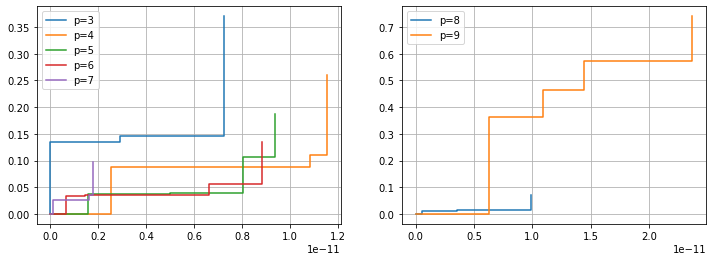

In [18]:
%%time
print("kSAT:")

ksat_ps = range(3, 10)
# number of jumps
k=4

# CONST_SQ may affect my convergence.
CONST_SQ = 1

num_vert_plots = int(np.ceil(len(ksat_ps)/10))
fig, axs = plt.subplots(num_vert_plots, 2, figsize=(12, 4*num_vert_plots))
outs = []
for idx in range(len(ksat_ps)):
    P = ksat_ps[idx]
    if idx % 5 == 0:
        ax = axs[(idx % 10) //5] #axs[idx // 10, (idx % 10)//5]
        ax.grid()
    # should xi be different by 1/2 ? I've seen it both ways.
    xi = lambda x: CONST_SQ* (-1 + (1+x)**P)
    xiprime = lambda x: CONST_SQ* P * ((1+x)**(P-1))
    xiprimeprime = lambda x:CONST_SQ* P * (P-1) * ((1+x)**(P-2))
    
    # find best function from minimizer
    best = None
    for _ in range(10):
        opt = minimize(test, 
                       [np.random.random()/k for _ in range(2*k)],
                       method='Powell', 
                       options={"ftol":1e-14}
                      )
        if not best or best.fun > opt.fun:
            best = opt
    print("p:", P, best.fun)
    outs.append(best.fun)

    qs = np.array([0,*[sum(best.x[:k][:i+1]) for i in range(k)]])
    ms = np.array([0,*[sum(best.x[k:][:i+1]) for i in range(k)]])
#     print("qs:", qs)
#     print("ms:", ms)
    ax.step(qs, ms, where='post', label="p=" + str(P))
    if idx % 5 == 4:
        ax.legend()

ax.legend()
outs = np.array(outs)

The constants after reducing by CONST_SQ (to help with convergence):

In [19]:
ksats_scaled = outs * CONST_SQ**-0.5

In [20]:
for p,o in zip(ksat_ps, ksats_scaled):
    print(p, o)

3 2.226107435645086
4 3.7566650783803763
5 5.848347563959985
6 8.734942217291879
7 12.748838841626227
8 18.362685897966173
9 20.018293212544904


I calculate $C$, where the satisfying fraction is $1-1/2^p + C/\sqrt{\alpha}$:

In [21]:
for p,o in zip(ksat_ps, ksats_scaled):
    print(p, o*2**(-p))

3 0.27826342945563576
4 0.23479156739877352
5 0.18276086137374953
6 0.1364834721451856
7 0.0996003034502049
8 0.07172924178893036
9 0.039098228930751766


It would be nice to get a confirmation on this constant, but I haven't seen it calculated anywhere.